In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure 2 is based on several important BED-files ...

In [4]:
feat_names = OrderedDict()
feat_names["ctcf"] = "intersect-all-NT-CTCF-NO-G4-centered"
feat_names["ctcf_g4"] = "intersect-all-NT-CTCF-G4-centered"
feat_names["g4"] = "intersect-G4-NO-CTCF-centered"
# feat_names["allg4"] = "G4-Mao-sort"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end"],
        usecols=(0,1,2),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


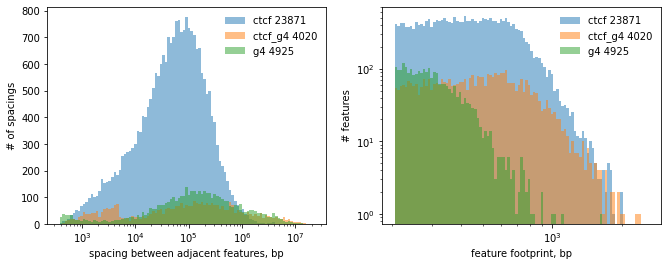

In [6]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)
# plot_spacing_footprint_distros({k:dfs[k] for k in ['ctcf']})
# plot_spacing_footprint_distros({k:dfs[k] for k in ['ctcf_g4']})
# plot_spacing_footprint_distros({k:dfs[k] for k in ['g4']})
# plot_spacing_footprint_distros({k:dfs[k] for k in ['allg4']})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

In [8]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [9]:
#let's describe our samples that we want to have in Figure 1 ...
fig2_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","polII"] #,"ddx_CTCF","ddx_noCTCF"]

titles = fig2_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig2_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [10]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features ctcf:(23871) ...


stacking up ctcf ...
CPU times: user 4.3 s, sys: 231 ms, total: 4.53 s
Wall time: 4.5 s
stacking up noctcf ...
CPU times: user 3.89 s, sys: 199 ms, total: 4.09 s
Wall time: 4.07 s
stacking up rad21_CTCF ...
CPU times: user 4.24 s, sys: 269 ms, total: 4.51 s
Wall time: 4.54 s
stacking up rad21_noCTCF ...
CPU times: user 3.64 s, sys: 144 ms, total: 3.78 s
Wall time: 3.77 s
stacking up ins_CTCF ...
CPU times: user 3.13 s, sys: 167 ms, total: 3.3 s
Wall time: 3.3 s
stacking up ins_noCTCF ...
CPU times: user 3.08 s, sys: 169 ms, total: 3.25 s
Wall time: 3.25 s
stacking up G4a_r2 ...
CPU times: user 5.29 s, sys: 238 ms, total: 5.53 s
Wall time: 5.52 s
stacking up polII ...
CPU times: user 3.04 s, sys: 163 ms, total: 3.21 s
Wall time: 3.22 s
going to stackup features ctcf_g4:(4020) ...


stacking up ctcf ...
CPU times: user 785 ms, sys: 48 ms, total: 833 ms
Wall time: 831 ms
stacking up noctcf ...
CPU times: user 705 ms, sys: 23.5 ms, total: 729 ms

In [11]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "gene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "gene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
fig2_samples.append(feat_name)
titles = fig2_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

# try to discriminate overlaping genes with the lack of genes  - white/gray  - fill missing nan ....

stacking genes up for ctcf ...
stacking genes up for ctcf_g4 ...
stacking genes up for g4 ...


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [12]:
# this is done INPLACE - be carefull !
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

for feature_key in stackup_dict:
    the_stackup = stackup_dict[feature_key]
    # define the size of the shoulder - flank size
    l, w = the_stackup["ins_CTCF"].shape
    norm_flank = int(w*0.25)

    normalize_insulation_stackups_INPLACE(
        the_stackup,
        insulation_keys,
        subtract = "shoulders",
        subtract_size = norm_flank,
    )

In [13]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.25,0.02)
    cmps[s] = cmapYlGnBu_r

In [14]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['rad21_CTCF'].shape
    center_bin = int(width/2)
#     the_stackups['ctcf_mean'] = np.nanmean(the_stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    _, _jjj = recursive_data_ordering(
        ks = [('rad21_mean', "sort", 1, False)],
        idxs = np.arange( length ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 23871 elements of rad21_mean into 1 groups ...
sorting 4020 elements of rad21_mean into 1 groups ...
sorting 4925 elements of rad21_mean into 1 groups ...


### calculate running average (in chunks of 100) number of called peaks along the stackup

In [15]:
# #
# #
CHUNK_SIZE = 100

G4_polstall_sorted = {}
Number_of_chunks = {}
for feature_key in ['ctcf', 'ctcf_g4', 'g4']:
    jjj = reordered_jdxs[feature_key]
    features_df = dfs[feature_key]
    # G4_polstall
    index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
    G4_polstall_sorted[feature_key] = []
    Number_of_chunks[feature_key] = 0
    _df2 = G4_polstall # works as is !!!
    for ii in index_chunks:
        _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
        G4_polstall_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
        Number_of_chunks[feature_key] += 1

#### plotting those running averages is integrated into `plot_stackups` function ...

In [16]:
##############################################
# now we'll be plotting stackups for different feature independently ...
#############################################
print('ctcf', 'ctcf_g4', 'g4')

ctcf ctcf_g4 g4


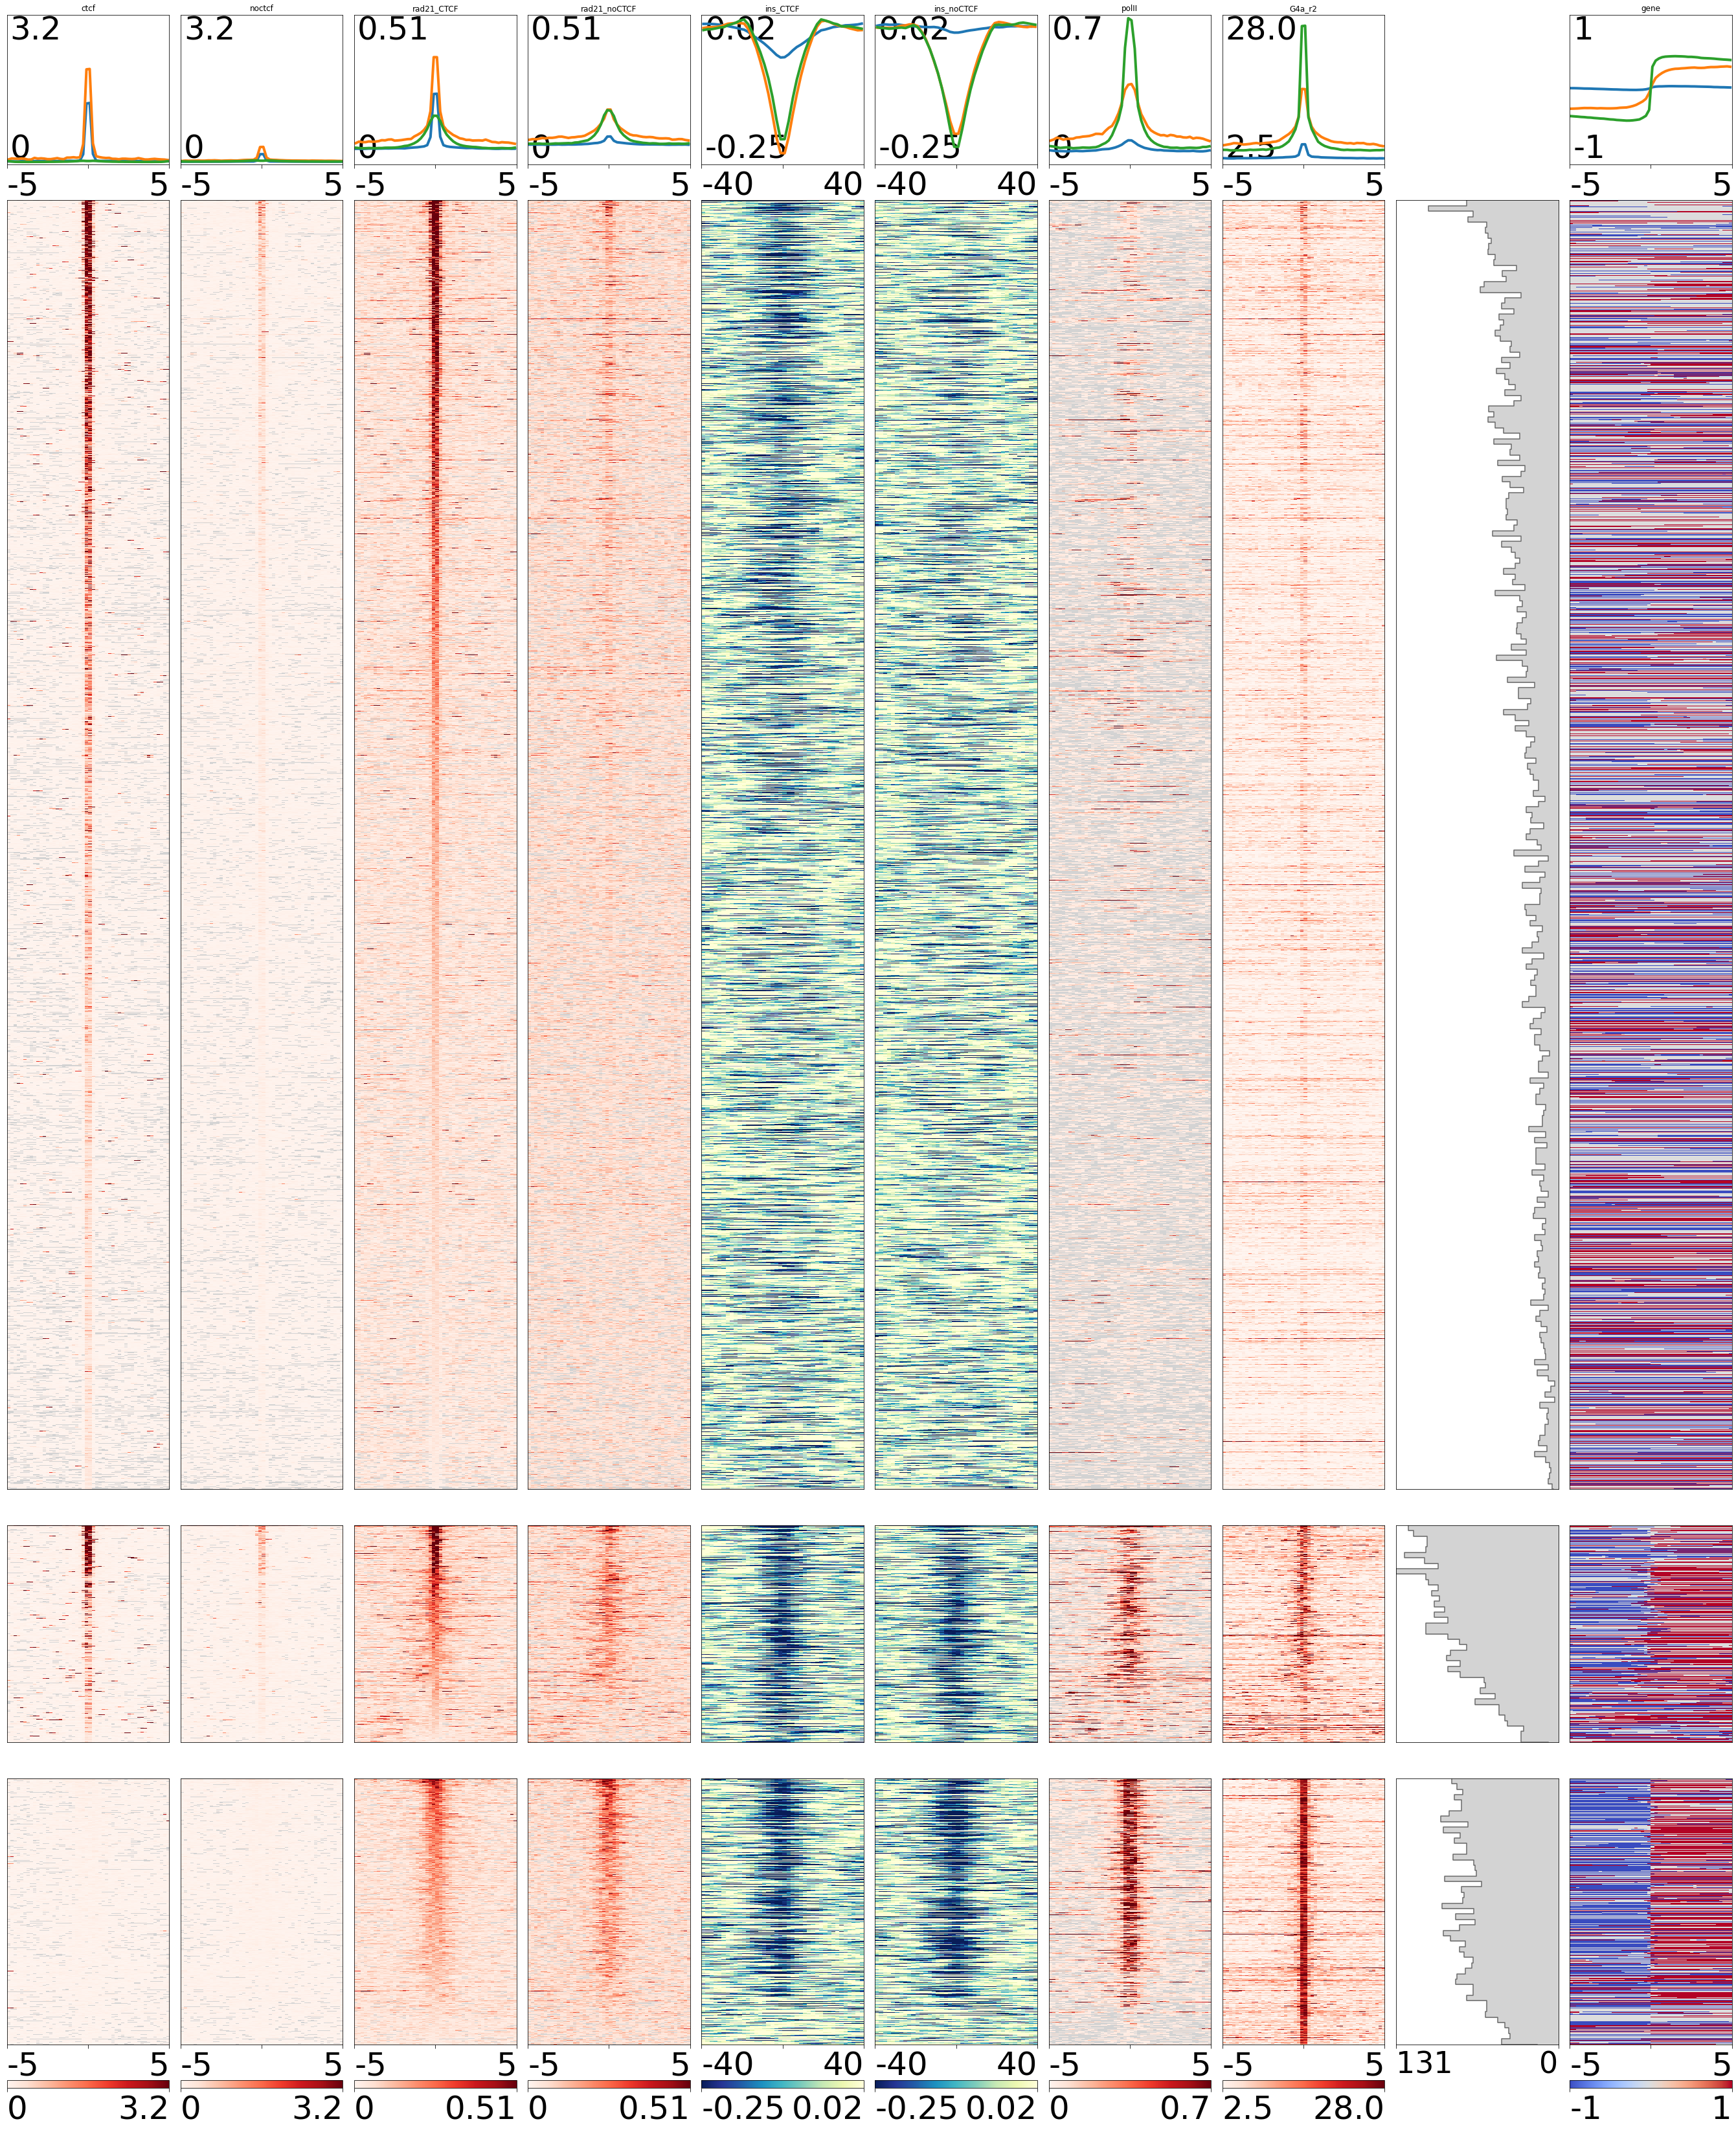

In [28]:
hmss = OrderedDict()

for feature_key in ['ctcf', 'ctcf_g4', 'g4']:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig2_samples ]

_limss = [ limss[_k] for _k in fig2_samples ]
_cmps = [ cmps[_k] for _k in fig2_samples ]
_binsizes = [ binsizes[_k] for _k in fig2_samples ]
_norms = [ norms[_k] for _k in fig2_samples ]

extra_order = [8,]
hmss_order = [0,1,2,3,4,5,7,6,9]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

# DEAL WITH XTRA PLOTS MANUALLY - AFTERWARDS ...
y,width,color = Number_of_chunks, G4_polstall_sorted, "lightgrey"
common_width_max = max(max(width[k]) for k in width)
col_index = extra_order[0]
for i, feature_key in enumerate(['ctcf', 'ctcf_g4', 'g4']):
    _y = np.arange(y[feature_key])
    _width = width[feature_key]
    _color = color
    xtra_axs[col_index][i].step(_width,_y,color="dimgray")
    xtra_axs[col_index][i].fill_betweenx(_y,0,_width,color=_color,step="post")
    xtra_axs[col_index][i].invert_yaxis()
    xtra_axs[col_index][i].invert_xaxis()
    xtra_axs[col_index][i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
    xtra_axs[col_index][i].set_ylim(max(_y), 0)
    xtra_axs[col_index][i].set_xlim(common_width_max,0)
    xtra_axs[col_index][i].set_yticks([])
    xtra_axs[col_index][i].set_yticklabels([])   
    xtra_axs[col_index][i].set_xticks([])
    xtra_axs[col_index][i].set_xticklabels([])
    if i == 2:
        xtra_axs[col_index][i].set_xticks([common_width_max,0])
        xtra_axs[col_index][i].set_xticklabels([common_width_max,0],fontsize=46)
        for _tidx, tick in enumerate(xtra_axs[col_index][i].xaxis.get_majorticklabels()):
            if _tidx == 0:
                tick.set_horizontalalignment("left")
            elif _tidx == 1:
                tick.set_horizontalalignment("right")
        xtra_axs[col_index][i].tick_params(axis="x", length=6)


plt.savefig("Fig2-Jul1.pdf")

In [29]:
! scp Fig2-Jul1.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

Fig2-Jul1.pdf                                 100% 2270KB 254.3KB/s   00:08    


In [20]:
# # check what we have here locally ...
# ! ls Fig2*pdf
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp Fig2* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/